In [1]:
import pandas as pd
import random
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split # 학습, 테스트set 구분
from sklearn.tree import export_graphviz # tree 시각화를 위해
import graphviz # tree 시각화
from sklearn.metrics import f1_score# 성능지표를 계산하기 위해 import
from sklearn.model_selection import cross_val_score, cross_validate # 교차검증

In [2]:
train_df = pd.read_csv('/content/drive/MyDrive/LGaimers/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/LGaimers/test.csv')

In [3]:
print(train_df.shape)
print(test_df.shape)

(598, 2881)
(310, 2879)


In [4]:
# 모두 결측치인 변수 제거
def remove_all_nan(dataframe):
  col_list = dataframe.columns
  nan_list = []
  nan_cnt = []
  nan_col = []
  full_list = []

  for col in col_list:
    if dataframe[col].isnull().sum() == 0:
      full_list.append(col)
      continue
    nan_list.append([col,dataframe[col].isnull().sum()])
    nan_cnt.append(dataframe[col].isnull().sum())
    nan_col.append(col)

  del_col = []
  for nan in nan_list:
    if nan[1] == len(dataframe):
      del_col.append(nan[0])
  
  return dataframe.drop(columns=del_col)

# LINE별 dataset 구축

In [5]:
train_T050304 = train_df[train_df['LINE'] == 'T050304']
train_T050307 = train_df[train_df['LINE'] == 'T050307']
train_T100304 = train_df[train_df['LINE'] == 'T100304']
train_T100306 = train_df[train_df['LINE'] == 'T100306']
train_T010306 = train_df[train_df['LINE'] == 'T010306']
train_T010305 = train_df[train_df['LINE'] == 'T010305']

In [6]:
test_T050304 = test_df[test_df['LINE'] == 'T050304']
test_T050307 = test_df[test_df['LINE'] == 'T050307']
test_T100304 = test_df[test_df['LINE'] == 'T100304']
test_T100306 = test_df[test_df['LINE'] == 'T100306']
test_T010306 = test_df[test_df['LINE'] == 'T010306']
test_T010305 = test_df[test_df['LINE'] == 'T010305']

test set에 존재하는 모두 nan인 변수에 대해 -1로 처리하는 것과 없애는 것 중 뭐가 좋은지는 논의해봐야할 것 같습니다.
  - 일단 없애지않고 진행하겠습니다.

In [7]:
print('train T050304 :' ,train_T050304['PRODUCT_CODE'].unique(), 'test T050304 :' ,test_T050304['PRODUCT_CODE'].unique())
print('train T050307 :' ,train_T050307['PRODUCT_CODE'].unique(), 'test T050307 :' ,test_T050307['PRODUCT_CODE'].unique())
print('train T100304 :' ,train_T100304['PRODUCT_CODE'].unique(), 'test T100304 :' ,test_T100304['PRODUCT_CODE'].unique())
print('train T100306 :' ,train_T100306['PRODUCT_CODE'].unique(), 'test T100306 :' ,test_T100306['PRODUCT_CODE'].unique())
print('train T010306 :' ,train_T010306['PRODUCT_CODE'].unique(), 'test T010306 :' ,test_T010306['PRODUCT_CODE'].unique())
print('train T010305 :' ,train_T010305['PRODUCT_CODE'].unique(), 'test T010305 :' ,test_T010305['PRODUCT_CODE'].unique())


train T050304 : ['A_31'] test T050304 : ['A_31']
train T050307 : ['A_31'] test T050307 : ['A_31']
train T100304 : ['T_31' 'O_31'] test T100304 : ['T_31' 'O_31']
train T100306 : ['T_31' 'O_31'] test T100306 : ['T_31' 'O_31']
train T010306 : ['A_31'] test T010306 : ['A_31']
train T010305 : ['A_31'] test T010305 : ['A_31']


In [8]:
# A 생성 LINE
train_T050304, test_T050304
train_T050307, test_T050307
train_T010306, test_T010306
train_T010305, test_T010305

# T, O 생성 LINE
train_T100304, test_T100304
train_T100306, test_T100306

(    PRODUCT_ID  Y_Class  Y_Quality         TIMESTAMP     LINE PRODUCT_CODE  \
 26   TRAIN_026        1   0.531992   2022-06-19 9:20  T100306         T_31   
 30   TRAIN_030        1   0.528646  2022-06-19 23:39  T100306         T_31   
 36   TRAIN_036        1   0.529633   2022-06-22 3:39  T100306         T_31   
 42   TRAIN_042        1   0.530965   2022-06-23 3:39  T100306         T_31   
 43   TRAIN_043        1   0.529498   2022-06-23 6:28  T100306         T_31   
 ..         ...      ...        ...               ...      ...          ...   
 589  TRAIN_589        1   0.529510  2022-09-06 18:00  T100306         T_31   
 590  TRAIN_590        1   0.529948   2022-09-07 1:01  T100306         T_31   
 591  TRAIN_591        1   0.529308   2022-09-07 1:09  T100306         T_31   
 593  TRAIN_593        1   0.526546  2022-09-08 14:30  T100306         T_31   
 597  TRAIN_597        1   0.533702  2022-09-08 14:46  T100306         O_31   
 
       X_1   X_2  X_3   X_4  ...  X_2866  X_2867  

## LINE별 train set은 최대한 구축 = 모두 NaN이 아니라면 mean을 적용
  - 단 y_class별로 나눠서 적용하는게 합리적인듯

PRODUCT_CODE A

Y_Class == 0

In [9]:
train_T050304[train_T050304['Y_Class'] == 0]

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
34,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03,52.24,55.33,57.49,67.31,1.0,NaN,NaN,NaN,NaN
109,TRAIN_109,0,0.516711,2022-07-06 19:15,T050304,A_31,NaN,NaN,NaN,NaN,...,56.86,50.46,40.49,57.34,66.37,1.0,NaN,NaN,NaN,NaN
110,TRAIN_110,0,0.519451,2022-07-06 19:23,T050304,A_31,NaN,NaN,NaN,NaN,...,48.28,51.25,55.43,56.95,67.44,1.0,NaN,NaN,NaN,NaN
111,TRAIN_111,0,0.518960,2022-07-06 20:41,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
131,TRAIN_131,0,0.519810,2022-07-10 0:57,T050304,A_31,NaN,NaN,NaN,NaN,...,52.97,59.15,42.29,57.22,65.46,1.0,NaN,NaN,NaN,NaN
132,TRAIN_132,0,0.521259,2022-07-10 1:05,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
202,TRAIN_202,0,0.521544,2022-07-21 4:53,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
255,TRAIN_255,0,0.515083,2022-07-25 12:39,T050304,A_31,NaN,NaN,NaN,NaN,...,60.24,56.16,54.52,56.42,66.85,1.0,NaN,NaN,NaN,NaN
322,TRAIN_322,0,0.522300,2022-07-31 22:37,T050304,A_31,NaN,NaN,NaN,NaN,...,55.99,52.08,40.90,55.31,62.80,1.0,NaN,NaN,NaN,NaN
344,TRAIN_344,0,0.524567,2022-08-03 8:28,T050304,A_31,NaN,NaN,NaN,NaN,...,54.63,59.05,40.77,55.24,64.69,1.0,NaN,NaN,NaN,NaN


In [10]:
train_T050304_0 = train_T050304[train_T050304['Y_Class'] == 0]
train_T050304_0 = train_T050304_0.fillna(train_T050304_0.mean())
train_T050304_0

<ipython-input-10-35cae4a997da>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050304_0 = train_T050304_0.fillna(train_T050304_0.mean())


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
34,TRAIN_034,0,0.521524,2022-06-21 17:36,T050304,A_31,NaN,NaN,NaN,NaN,...,55.03000,52.240000,55.330000,57.490000,67.31,1.0,NaN,NaN,NaN,NaN
109,TRAIN_109,0,0.516711,2022-07-06 19:15,T050304,A_31,NaN,NaN,NaN,NaN,...,56.86000,50.460000,40.490000,57.340000,66.37,1.0,NaN,NaN,NaN,NaN
110,TRAIN_110,0,0.519451,2022-07-06 19:23,T050304,A_31,NaN,NaN,NaN,NaN,...,48.28000,51.250000,55.430000,56.950000,67.44,1.0,NaN,NaN,NaN,NaN
111,TRAIN_111,0,0.518960,2022-07-06 20:41,T050304,A_31,NaN,NaN,NaN,NaN,...,53.06875,55.684167,49.493333,55.706667,65.04,1.0,NaN,NaN,NaN,NaN
131,TRAIN_131,0,0.519810,2022-07-10 0:57,T050304,A_31,NaN,NaN,NaN,NaN,...,52.97000,59.150000,42.290000,57.220000,65.46,1.0,NaN,NaN,NaN,NaN
132,TRAIN_132,0,0.521259,2022-07-10 1:05,T050304,A_31,NaN,NaN,NaN,NaN,...,53.06875,55.684167,49.493333,55.706667,65.04,1.0,NaN,NaN,NaN,NaN
202,TRAIN_202,0,0.521544,2022-07-21 4:53,T050304,A_31,NaN,NaN,NaN,NaN,...,53.06875,55.684167,49.493333,55.706667,65.04,1.0,NaN,NaN,NaN,NaN
255,TRAIN_255,0,0.515083,2022-07-25 12:39,T050304,A_31,NaN,NaN,NaN,NaN,...,60.24000,56.160000,54.520000,56.420000,66.85,1.0,NaN,NaN,NaN,NaN
322,TRAIN_322,0,0.522300,2022-07-31 22:37,T050304,A_31,NaN,NaN,NaN,NaN,...,55.99000,52.080000,40.900000,55.310000,62.80,1.0,NaN,NaN,NaN,NaN
344,TRAIN_344,0,0.524567,2022-08-03 8:28,T050304,A_31,NaN,NaN,NaN,NaN,...,54.63000,59.050000,40.770000,55.240000,64.69,1.0,NaN,NaN,NaN,NaN


Y_Class == 1

In [11]:
train_T050304[train_T050304['Y_Class'] == 1]

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
10,TRAIN_010,1,0.531503,2022-06-13 6:36,T050304,A_31,NaN,NaN,NaN,NaN,...,32.12,34.74,54.93,33.16,76.30,NaN,NaN,NaN,NaN,NaN
12,TRAIN_012,1,0.533632,2022-06-13 6:52,T050304,A_31,NaN,NaN,NaN,NaN,...,36.55,32.32,54.25,35.15,78.86,NaN,NaN,NaN,NaN,NaN
14,TRAIN_014,1,0.531254,2022-06-13 7:08,T050304,A_31,NaN,NaN,NaN,NaN,...,40.42,38.33,40.14,30.72,76.52,NaN,NaN,NaN,NaN,NaN
16,TRAIN_016,1,0.534054,2022-06-13 7:25,T050304,A_31,NaN,NaN,NaN,NaN,...,40.53,31.70,49.49,35.73,79.75,NaN,NaN,NaN,NaN,NaN
18,TRAIN_018,1,0.532170,2022-06-13 7:41,T050304,A_31,NaN,NaN,NaN,NaN,...,35.07,48.38,36.24,33.00,75.82,NaN,NaN,NaN,NaN,NaN


In [12]:
train_T050304_1 = train_T050304[train_T050304['Y_Class'] == 1]
train_T050304_1 = train_T050304_1.fillna(train_T050304_1.mean())
train_T050304_1

<ipython-input-12-86148b85403a>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050304_1 = train_T050304_1.fillna(train_T050304_1.mean())


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.340000,40.890000,32.560000,34.090000,77.770000,1.0,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.190000,36.650000,42.470000,36.530000,78.350000,1.0,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.700000,41.890000,46.930000,33.090000,76.970000,1.0,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.500000,41.420000,38.360000,30.830000,76.930000,1.0,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.250000,43.170000,55.600000,33.260000,78.500000,1.0,NaN,NaN,NaN,NaN
10,TRAIN_010,1,0.531503,2022-06-13 6:36,T050304,A_31,NaN,NaN,NaN,NaN,...,32.120000,34.740000,54.930000,33.160000,76.300000,1.0,NaN,NaN,NaN,NaN
12,TRAIN_012,1,0.533632,2022-06-13 6:52,T050304,A_31,NaN,NaN,NaN,NaN,...,36.550000,32.320000,54.250000,35.150000,78.860000,1.0,NaN,NaN,NaN,NaN
14,TRAIN_014,1,0.531254,2022-06-13 7:08,T050304,A_31,NaN,NaN,NaN,NaN,...,40.420000,38.330000,40.140000,30.720000,76.520000,1.0,NaN,NaN,NaN,NaN
16,TRAIN_016,1,0.534054,2022-06-13 7:25,T050304,A_31,NaN,NaN,NaN,NaN,...,40.530000,31.700000,49.490000,35.730000,79.750000,1.0,NaN,NaN,NaN,NaN
18,TRAIN_018,1,0.532170,2022-06-13 7:41,T050304,A_31,NaN,NaN,NaN,NaN,...,35.070000,48.380000,36.240000,33.000000,75.820000,1.0,NaN,NaN,NaN,NaN


Y_Class == 2

In [13]:
train_T050304[train_T050304['Y_Class'] == 2]

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
21,TRAIN_021,2,0.544129,2022-06-14 5:58,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
79,TRAIN_079,2,0.538629,2022-07-01 0:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.49,55.59,60.00,58.18,66.79,1.0,NaN,NaN,NaN,NaN
80,TRAIN_080,2,0.537733,2022-07-01 1:11,T050304,A_31,NaN,NaN,NaN,NaN,...,55.89,63.42,42.71,57.03,66.20,1.0,NaN,NaN,NaN,NaN
188,TRAIN_188,2,0.535405,2022-07-19 6:27,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
314,TRAIN_314,2,0.537046,2022-07-31 14:15,T050304,A_31,NaN,NaN,NaN,NaN,...,53.49,58.06,33.43,54.71,61.93,1.0,NaN,NaN,NaN,NaN
315,TRAIN_315,2,0.535965,2022-07-31 14:53,T050304,A_31,NaN,NaN,NaN,NaN,...,56.71,61.84,40.60,56.59,65.12,1.0,NaN,NaN,NaN,NaN
556,TRAIN_556,2,0.560568,2022-08-28 2:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.49,58.76,42.22,57.92,66.18,1.0,NaN,NaN,NaN,NaN
557,TRAIN_557,2,0.559463,2022-08-28 3:03,T050304,A_31,NaN,NaN,NaN,NaN,...,50.87,57.13,53.07,56.21,67.22,1.0,NaN,NaN,NaN,NaN
562,TRAIN_562,2,0.541429,2022-09-03 1:14,T050304,A_31,NaN,NaN,NaN,NaN,...,56.38,57.10,51.49,56.08,64.40,1.0,NaN,NaN,NaN,NaN
563,TRAIN_563,2,0.537465,2022-09-03 1:22,T050304,A_31,NaN,NaN,NaN,NaN,...,49.92,54.66,50.56,48.63,62.17,1.0,NaN,NaN,NaN,NaN


In [14]:
train_T050304_2 = train_T050304[train_T050304['Y_Class'] == 2]
train_T050304_2 = train_T050304_2.fillna(train_T050304_2.mean())
train_T050304_2

<ipython-input-14-84835eb1afdf>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050304_2 = train_T050304_2.fillna(train_T050304_2.mean())


,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
21,TRAIN_021,2,0.544129,2022-06-14 5:58,T050304,A_31,NaN,NaN,NaN,NaN,...,54.242222,58.044444,47.48,55.785556,64.908889,1.0,NaN,NaN,NaN,NaN
79,TRAIN_079,2,0.538629,2022-07-01 0:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,55.590000,60.00,58.180000,66.790000,1.0,NaN,NaN,NaN,NaN
80,TRAIN_080,2,0.537733,2022-07-01 1:11,T050304,A_31,NaN,NaN,NaN,NaN,...,55.890000,63.420000,42.71,57.030000,66.200000,1.0,NaN,NaN,NaN,NaN
188,TRAIN_188,2,0.535405,2022-07-19 6:27,T050304,A_31,NaN,NaN,NaN,NaN,...,54.242222,58.044444,47.48,55.785556,64.908889,1.0,NaN,NaN,NaN,NaN
314,TRAIN_314,2,0.537046,2022-07-31 14:15,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,58.060000,33.43,54.710000,61.930000,1.0,NaN,NaN,NaN,NaN
315,TRAIN_315,2,0.535965,2022-07-31 14:53,T050304,A_31,NaN,NaN,NaN,NaN,...,56.710000,61.840000,40.60,56.590000,65.120000,1.0,NaN,NaN,NaN,NaN
556,TRAIN_556,2,0.560568,2022-08-28 2:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,58.760000,42.22,57.920000,66.180000,1.0,NaN,NaN,NaN,NaN
557,TRAIN_557,2,0.559463,2022-08-28 3:03,T050304,A_31,NaN,NaN,NaN,NaN,...,50.870000,57.130000,53.07,56.210000,67.220000,1.0,NaN,NaN,NaN,NaN
562,TRAIN_562,2,0.541429,2022-09-03 1:14,T050304,A_31,NaN,NaN,NaN,NaN,...,56.380000,57.100000,51.49,56.080000,64.400000,1.0,NaN,NaN,NaN,NaN
563,TRAIN_563,2,0.537465,2022-09-03 1:22,T050304,A_31,NaN,NaN,NaN,NaN,...,49.920000,54.660000,50.56,48.630000,62.170000,1.0,NaN,NaN,NaN,NaN


In [15]:
train_T050304_2

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
21,TRAIN_021,2,0.544129,2022-06-14 5:58,T050304,A_31,NaN,NaN,NaN,NaN,...,54.242222,58.044444,47.48,55.785556,64.908889,1.0,NaN,NaN,NaN,NaN
79,TRAIN_079,2,0.538629,2022-07-01 0:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,55.590000,60.00,58.180000,66.790000,1.0,NaN,NaN,NaN,NaN
80,TRAIN_080,2,0.537733,2022-07-01 1:11,T050304,A_31,NaN,NaN,NaN,NaN,...,55.890000,63.420000,42.71,57.030000,66.200000,1.0,NaN,NaN,NaN,NaN
188,TRAIN_188,2,0.535405,2022-07-19 6:27,T050304,A_31,NaN,NaN,NaN,NaN,...,54.242222,58.044444,47.48,55.785556,64.908889,1.0,NaN,NaN,NaN,NaN
314,TRAIN_314,2,0.537046,2022-07-31 14:15,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,58.060000,33.43,54.710000,61.930000,1.0,NaN,NaN,NaN,NaN
315,TRAIN_315,2,0.535965,2022-07-31 14:53,T050304,A_31,NaN,NaN,NaN,NaN,...,56.710000,61.840000,40.60,56.590000,65.120000,1.0,NaN,NaN,NaN,NaN
556,TRAIN_556,2,0.560568,2022-08-28 2:54,T050304,A_31,NaN,NaN,NaN,NaN,...,53.490000,58.760000,42.22,57.920000,66.180000,1.0,NaN,NaN,NaN,NaN
557,TRAIN_557,2,0.559463,2022-08-28 3:03,T050304,A_31,NaN,NaN,NaN,NaN,...,50.870000,57.130000,53.07,56.210000,67.220000,1.0,NaN,NaN,NaN,NaN
562,TRAIN_562,2,0.541429,2022-09-03 1:14,T050304,A_31,NaN,NaN,NaN,NaN,...,56.380000,57.100000,51.49,56.080000,64.400000,1.0,NaN,NaN,NaN,NaN
563,TRAIN_563,2,0.537465,2022-09-03 1:22,T050304,A_31,NaN,NaN,NaN,NaN,...,49.920000,54.660000,50.56,48.630000,62.170000,1.0,NaN,NaN,NaN,NaN


In [16]:
train_T050304

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,TRAIN_581,0,0.523465,2022-09-05 8:18,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
582,TRAIN_582,0,0.522233,2022-09-05 8:26,T050304,A_31,NaN,NaN,NaN,NaN,...,50.88,53.23,52.44,56.28,66.83,1.0,NaN,NaN,NaN,NaN
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN


In [17]:
train_T050304.set_index('PRODUCT_ID', inplace=True)
train_T050304

,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
PRODUCT_ID,,,,,,,,,,,,,,,,,,,,,
TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,32.50,41.42,38.36,30.83,76.93,NaN,NaN,NaN,NaN,NaN
TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,42.25,43.17,55.60,33.26,78.50,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TRAIN_581,0,0.523465,2022-09-05 8:18,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
TRAIN_582,0,0.522233,2022-09-05 8:26,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,50.88,53.23,52.44,56.28,66.83,1.0,NaN,NaN,NaN,NaN
TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,NaN,...,51.71,59.64,54.61,57.05,63.18,1.0,NaN,NaN,NaN,NaN


In [18]:
train_T050304= pd.concat([train_T050304_0,train_T050304_1,train_T050304_2]).sort_values(by='PRODUCT_ID')
train_T050304

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34000,40.890000,32.560000,34.090000,77.77,1.0,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19000,36.650000,42.470000,36.530000,78.35,1.0,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70000,41.890000,46.930000,33.090000,76.97,1.0,NaN,NaN,NaN,NaN
6,TRAIN_006,1,0.533665,2022-06-13 6:03,T050304,A_31,NaN,NaN,NaN,NaN,...,32.50000,41.420000,38.360000,30.830000,76.93,1.0,NaN,NaN,NaN,NaN
8,TRAIN_008,1,0.531821,2022-06-13 6:19,T050304,A_31,NaN,NaN,NaN,NaN,...,42.25000,43.170000,55.600000,33.260000,78.50,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,TRAIN_581,0,0.523465,2022-09-05 8:18,T050304,A_31,NaN,NaN,NaN,NaN,...,53.06875,55.684167,49.493333,55.706667,65.04,1.0,NaN,NaN,NaN,NaN
582,TRAIN_582,0,0.522233,2022-09-05 8:26,T050304,A_31,NaN,NaN,NaN,NaN,...,50.88000,53.230000,52.440000,56.280000,66.83,1.0,NaN,NaN,NaN,NaN
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71000,59.640000,54.610000,57.050000,63.18,1.0,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47000,53.070000,50.890000,55.100000,66.49,1.0,NaN,NaN,NaN,NaN


In [19]:
train_T050307_0 = train_T050307[train_T050307['Y_Class'] == 0]
train_T050307_0 = train_T050307_0.fillna(train_T050307_0.mean())

train_T050307_1 = train_T050307[train_T050307['Y_Class'] == 1]
train_T050307_1 = train_T050307_1.fillna(train_T050307_1.mean())

train_T050307_2 = train_T050307[train_T050307['Y_Class'] == 2]
train_T050307_2 = train_T050307_2.fillna(train_T050307_2.mean())

train_T050307= pd.concat([train_T050307_0,train_T050307_1,train_T050307_2]).sort_values(by='PRODUCT_ID')

<ipython-input-19-ca7940832263>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050307_0 = train_T050307_0.fillna(train_T050307_0.mean())
<ipython-input-19-ca7940832263>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050307_1 = train_T050307_1.fillna(train_T050307_1.mean())
<ipython-input-19-ca7940832263>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T050307_2 = train_T050307_2.fillna(train_T050307_2.mean())


In [20]:
train_T010306_0 = train_T010306[train_T010306['Y_Class'] == 0]
train_T010306_0 = train_T010306_0.fillna(train_T010306_0.mean())

train_T010306_1 = train_T010306[train_T010306['Y_Class'] == 1]
train_T010306_1 = train_T010306_1.fillna(train_T010306_1.mean())

train_T010306_2 = train_T010306[train_T010306['Y_Class'] == 2]
train_T010306_2 = train_T010306_2.fillna(train_T010306_2.mean())

train_T010306= pd.concat([train_T010306_0,train_T010306_1,train_T010306_2]).sort_values(by='PRODUCT_ID')

<ipython-input-20-065f802ddf62>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010306_0 = train_T010306_0.fillna(train_T010306_0.mean())
<ipython-input-20-065f802ddf62>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010306_1 = train_T010306_1.fillna(train_T010306_1.mean())
<ipython-input-20-065f802ddf62>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010306_2 = train_T010306_2.fillna(train_T010306_2.mean())


In [21]:
train_T010305_0 = train_T010305[train_T010305['Y_Class'] == 0]
train_T010305_0 = train_T010305_0.fillna(train_T010305_0.mean())

train_T010305_1 = train_T010305[train_T010305['Y_Class'] == 1]
train_T010305_1 = train_T010305_1.fillna(train_T010305_1.mean())

train_T010305_2 = train_T010305[train_T010305['Y_Class'] == 2]
train_T010305_2 = train_T010305_2.fillna(train_T010305_2.mean())

train_T010305= pd.concat([train_T010305_0,train_T010305_1,train_T010305_2]).sort_values(by='PRODUCT_ID')

<ipython-input-21-d9421a2d1196>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010305_0 = train_T010305_0.fillna(train_T010305_0.mean())
<ipython-input-21-d9421a2d1196>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010305_1 = train_T010305_1.fillna(train_T010305_1.mean())
<ipython-input-21-d9421a2d1196>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T010305_2 = train_T010305_2.fillna(train_T010305_2.mean())


In [22]:
trainA_31 = pd.concat([train_T050304,train_T050307,train_T010306,train_T010305]).sort_values(by='PRODUCT_ID')
trainA_31

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34000,40.890000,32.560000,34.090000,77.77,1.0,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89000,42.820000,43.920000,35.340000,72.55,1.0,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19000,36.650000,42.470000,36.530000,78.35,1.0,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74000,39.170000,52.170000,30.580000,71.78,1.0,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70000,41.890000,46.930000,33.090000,76.97,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71000,59.640000,54.610000,57.050000,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47000,53.070000,50.890000,55.100000,66.49,1.0,NaN,NaN,NaN,NaN


PRODUCT_CODE = T

In [23]:
train_T100304[train_T100304['PRODUCT_CODE'] == 'T_31']
train_T100304[train_T100304['PRODUCT_CODE'] == 'O_31']

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
train_T100306[train_T100306['PRODUCT_CODE'] == 'O_31']

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
train_T100304_T = train_T100304[train_T100304['PRODUCT_CODE'] == 'T_31']

In [26]:
train_T100304_T_0 = train_T100304_T[train_T100304_T['Y_Class'] == 0]
train_T100304_T_0 = train_T100304_T_0.fillna(train_T100304_T_0.mean())

train_T100304_T_1 = train_T100304_T[train_T100304_T['Y_Class'] == 1]
train_T100304_T_1 = train_T100304_T_1.fillna(train_T100304_T_1.mean())

train_T100304_T_2 = train_T100304_T[train_T100304_T['Y_Class'] == 2]
train_T100304_T_2 = train_T100304_T_2.fillna(train_T100304_T_2.mean())

train_T100304_T = pd.concat([train_T100304_T_0,train_T100304_T_1,train_T100304_T_2]).sort_values(by='PRODUCT_ID')

<ipython-input-26-c6e13ab352d5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100304_T_0 = train_T100304_T_0.fillna(train_T100304_T_0.mean())
<ipython-input-26-c6e13ab352d5>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100304_T_1 = train_T100304_T_1.fillna(train_T100304_T_1.mean())
<ipython-input-26-c6e13ab352d5>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100304_T_2 = train_T100304_T_2.fillna(train_T100304_T_2.mean())


In [27]:
train_T100306_T = train_T100306[train_T100306['PRODUCT_CODE'] == 'T_31']

In [28]:
train_T100306_T_0 = train_T100306_T[train_T100306_T['Y_Class'] == 0]
train_T100306_T_0 = train_T100306_T_0.fillna(train_T100306_T_0.mean())

train_T100306_T_1 = train_T100306_T[train_T100306_T['Y_Class'] == 1]
train_T100306_T_1 = train_T100306_T_1.fillna(train_T100306_T_1.mean())

train_T100306_T_2 = train_T100306_T[train_T100306_T['Y_Class'] == 2]
train_T100306_T_2 = train_T100306_T_2.fillna(train_T100306_T_2.mean())

train_T100306_T = pd.concat([train_T100306_T_0,train_T100306_T_1,train_T100306_T_2]).sort_values(by='PRODUCT_ID')

<ipython-input-28-fa6e6afbec0f>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100306_T_0 = train_T100306_T_0.fillna(train_T100306_T_0.mean())
<ipython-input-28-fa6e6afbec0f>:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100306_T_1 = train_T100306_T_1.fillna(train_T100306_T_1.mean())
<ipython-input-28-fa6e6afbec0f>:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100306_T_2 = train_T100306_T_2.fillna(train_T100306_T_2.mean())


In [29]:
trainT_31 = pd.concat([train_T100304_T,train_T100306_T]).sort_values(by='PRODUCT_ID')
trainT_31

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
22,TRAIN_022,0,0.517719,2022-06-14 8:53,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,TRAIN_023,0,0.519090,2022-06-14 9:01,T100304,T_31,2.0,102.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,TRAIN_025,1,0.529362,2022-06-19 9:11,T100304,T_31,2.0,97.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,TRAIN_026,1,0.531992,2022-06-19 9:20,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29,TRAIN_029,1,0.532405,2022-06-19 23:31,T100304,T_31,2.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,TRAIN_589,1,0.529510,2022-09-06 18:00,T100306,T_31,1.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590,TRAIN_590,1,0.529948,2022-09-07 1:01,T100306,T_31,1.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
591,TRAIN_591,1,0.529308,2022-09-07 1:09,T100306,T_31,1.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
592,TRAIN_592,1,0.528349,2022-09-08 14:22,T100304,T_31,2.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


PRODUCT_CODE O

In [30]:
train_T100304_O = train_T100304[train_T100304['PRODUCT_CODE'] == 'O_31']

train_T100304_O_0 = train_T100304_O[train_T100304_O['Y_Class'] == 0]
train_T100304_O_0 = train_T100304_O_0.fillna(train_T100304_O_0.mean())

train_T100304_O_1 = train_T100304_O[train_T100304_O['Y_Class'] == 1]
train_T100304_O_1 = train_T100304_O_1.fillna(train_T100304_O_1.mean())

train_T100304_O_2 = train_T100304_O[train_T100304_O['Y_Class'] == 2]
train_T100304_O_2 = train_T100304_O_2.fillna(train_T100304_O_2.mean())

train_T100304_O = pd.concat([train_T100304_O_0,train_T100304_O_1,train_T100304_O_2]).sort_values(by='PRODUCT_ID')

<ipython-input-30-eb0a1cfa0032>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100304_O_1 = train_T100304_O_1.fillna(train_T100304_O_1.mean())


In [31]:
train_T100306_O = train_T100306[train_T100306['PRODUCT_CODE'] == 'O_31']

train_T100306_O_0 = train_T100306_O[train_T100306_O['Y_Class'] == 0]
train_T100306_O_0 = train_T100306_O_0.fillna(train_T100306_O_0.mean())

train_T100306_O_1 = train_T100306_O[train_T100306_O['Y_Class'] == 1]
train_T100306_O_1 = train_T100306_O_1.fillna(train_T100306_O_1.mean())

train_T100306_O_2 = train_T100306_O[train_T100306_O['Y_Class'] == 2]
train_T100306_O_2 = train_T100306_O_2.fillna(train_T100306_O_2.mean())

train_T100306_O = pd.concat([train_T100306_O_0,train_T100306_O_1,train_T100306_O_2]).sort_values(by='PRODUCT_ID')

<ipython-input-31-e7590985a3c7>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100306_O_1 = train_T100306_O_1.fillna(train_T100306_O_1.mean())
<ipython-input-31-e7590985a3c7>:10: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_T100306_O_2 = train_T100306_O_2.fillna(train_T100306_O_2.mean())


In [32]:
trainO_31 = pd.concat([train_T100304_O,train_T100306_O]).sort_values(by='PRODUCT_ID')
trainO_31

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
569,TRAIN_569,1,0.530533,2022-09-03 18:32,T100304,O_31,4.0,98.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
570,TRAIN_570,2,0.534951,2022-09-03 18:40,T100306,O_31,6.0,90.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
571,TRAIN_571,1,0.525916,2022-09-03 18:48,T100304,O_31,4.0,100.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
572,TRAIN_572,2,0.535205,2022-09-03 18:56,T100306,O_31,6.0,89.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
597,TRAIN_597,1,0.533702,2022-09-08 14:46,T100306,O_31,21.0,87.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# product code별 학습진행
  - LINE 별 dataset 에서 Y_Class별로 나누어 mean 적용(결측치 없앰)
  - 나머지 존재하는 NaN에 대해서는 -1 대체 (변수가 의미없음을 의미)
  - 변수개수는 줄이지 않았음
  - PRODUCT_CODE O는 6개 존재(Y_Class = 1 4개, Y_Class = 2 2개) -> 이는 분류 보단 회귀 이후 라벨링이 적절해보임.

Dataset:  
- trainA_31  
- trainT_31  
- trainO_31

## test nan 처리에 대해 고민해봐야할듯
- test에도 O는 4개밖에 없어서 O를 맞추는 거는 크게 고민 안해도 될듯
- A와 T위주로 맞추는걸로

In [33]:
trainA_31

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 5:14,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34000,40.890000,32.560000,34.090000,77.77,1.0,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89000,42.820000,43.920000,35.340000,72.55,1.0,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 5:30,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19000,36.650000,42.470000,36.530000,78.35,1.0,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74000,39.170000,52.170000,30.580000,71.78,1.0,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 5:47,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70000,41.890000,46.930000,33.090000,76.97,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
583,TRAIN_583,0,0.522340,2022-09-05 8:34,T050304,A_31,NaN,NaN,NaN,NaN,...,51.71000,59.640000,54.610000,57.050000,63.18,1.0,NaN,NaN,NaN,NaN
584,TRAIN_584,0,0.519519,2022-09-05 11:09,T010305,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
585,TRAIN_585,0,0.515214,2022-09-05 11:17,T010306,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47000,53.070000,50.890000,55.100000,66.49,1.0,NaN,NaN,NaN,NaN


In [34]:
testA_31 = test_df[test_df['PRODUCT_CODE'] == 'A_31']
testT_31 = test_df[test_df['PRODUCT_CODE'] == 'T_31']
testO_31 = test_df[test_df['PRODUCT_CODE'] == 'O_31']

In [35]:
testA_31

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
3,TEST_003,2022-09-09 10:56,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,TEST_005,2022-09-09 19:35,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,TEST_006,2022-09-09 19:43,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,TEST_007,2022-09-10 12:27,T050304,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,57.74,52.51,54.45,57.99,63.16,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,TEST_284,2022-11-03 9:53,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,52.97,58.06,44.11,56.33,62.00,1.0,263.4,257.5,261.0,236.3
285,TEST_285,2022-11-03 10:01,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,54.24,55.55,51.60,48.53,61.95,1.0,267.6,278.6,271.4,243.3
286,TEST_286,2022-11-03 11:31,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,58.06,57.92,49.06,48.26,62.77,1.0,199.0,223.8,169.7,198.7
292,TEST_292,2022-11-04 0:31,T050307,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9


In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [37]:
mice_A = pd.concat([trainA_31, testA_31])
mice_T = pd.concat([trainT_31, testT_31])
mice_O = pd.concat([trainO_31, testO_31])

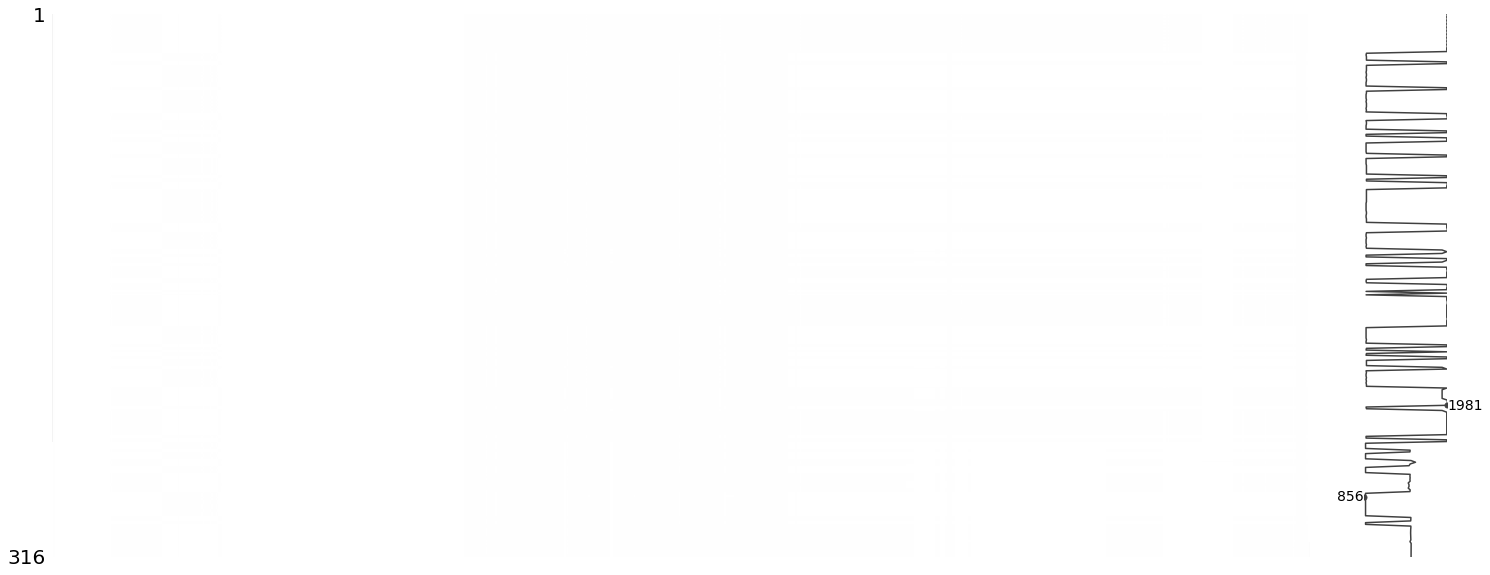

In [38]:
import missingno as msno
msno.matrix(mice_A)

In [39]:
mice_A = remove_all_nan(mice_A)

In [40]:
mice_A

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_128,X_129,X_130,X_131,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1.0,0.533433,2022-06-13 5:14,T050304,A_31,7813.0,7813.0,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,1.0,NaN,NaN,NaN,NaN
1,TRAIN_001,2.0,0.541819,2022-06-13 5:22,T050307,A_31,NaN,NaN,19854.0,19854.0,...,38.89,42.82,43.92,35.34,72.55,1.0,NaN,NaN,NaN,NaN
2,TRAIN_002,1.0,0.531267,2022-06-13 5:30,T050304,A_31,7815.0,7815.0,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,1.0,NaN,NaN,NaN,NaN
3,TRAIN_003,2.0,0.537325,2022-06-13 5:39,T050307,A_31,NaN,NaN,19856.0,19856.0,...,37.74,39.17,52.17,30.58,71.78,1.0,NaN,NaN,NaN,NaN
4,TRAIN_004,1.0,0.531590,2022-06-13 5:47,T050304,A_31,7817.0,7817.0,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,1.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,TEST_284,NaN,NaN,2022-11-03 9:53,T050307,A_31,NaN,NaN,19591.0,24422.0,...,52.97,58.06,44.11,56.33,62.00,1.0,263.4,257.5,261.0,236.3
285,TEST_285,NaN,NaN,2022-11-03 10:01,T050307,A_31,NaN,NaN,19621.0,24452.0,...,54.24,55.55,51.60,48.53,61.95,1.0,267.6,278.6,271.4,243.3
286,TEST_286,NaN,NaN,2022-11-03 11:31,T050307,A_31,NaN,NaN,19646.0,24476.0,...,58.06,57.92,49.06,48.26,62.77,1.0,199.0,223.8,169.7,198.7
292,TEST_292,NaN,NaN,2022-11-04 0:31,T050307,A_31,NaN,NaN,20153.0,24984.0,...,53.55,52.68,49.97,56.66,63.52,1.0,210.5,214.6,201.6,191.9


In [41]:
mice_A = mice_A.drop(columns=['PRODUCT_ID','TIMESTAMP','PRODUCT_CODE','Y_Class','Y_Quality'])
mice_A = pd.get_dummies(mice_A)
mice_A

,X_128,X_129,X_130,X_131,X_132,X_133,X_134,X_135,X_136,X_137,...,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875,LINE_T010305,LINE_T010306,LINE_T050304,LINE_T050307
0,7813.0,7813.0,NaN,NaN,0.19,0.20,0.19,0.2,228.0,228.0,...,77.77,1.0,NaN,NaN,NaN,NaN,0,0,1,0
1,NaN,NaN,19854.0,19854.0,0.20,0.21,0.20,0.2,413.0,414.0,...,72.55,1.0,NaN,NaN,NaN,NaN,0,0,0,1
2,7815.0,7815.0,NaN,NaN,0.19,0.20,0.19,0.2,228.0,228.0,...,78.35,1.0,NaN,NaN,NaN,NaN,0,0,1,0
3,NaN,NaN,19856.0,19856.0,0.20,0.21,0.20,0.2,414.0,414.0,...,71.78,1.0,NaN,NaN,NaN,NaN,0,0,0,1
4,7817.0,7817.0,NaN,NaN,0.19,0.20,0.18,0.2,228.0,228.0,...,76.97,1.0,NaN,NaN,NaN,NaN,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,NaN,NaN,19591.0,24422.0,0.21,0.22,0.21,0.2,806.0,805.0,...,62.00,1.0,263.4,257.5,261.0,236.3,0,0,0,1
285,NaN,NaN,19621.0,24452.0,0.21,0.22,0.21,0.2,806.0,805.0,...,61.95,1.0,267.6,278.6,271.4,243.3,0,0,0,1
286,NaN,NaN,19646.0,24476.0,0.21,0.22,0.21,0.2,807.0,806.0,...,62.77,1.0,199.0,223.8,169.7,198.7,0,0,0,1
292,NaN,NaN,20153.0,24984.0,0.21,0.22,0.21,0.2,821.0,820.0,...,63.52,1.0,210.5,214.6,201.6,191.9,0,0,0,1


In [ ]:
mice_A = pd.DataFrame(IterativeImputer(verbose=False).fit_transform(mice_A))